In [38]:
%load_ext autoreload
%autoreload 2

import util as yu
from util import *

yu.setpath('analysis_c2pt')

projs=['P0', 'Px', 'Py', 'Pz']
inserts=['tt', 'tx', 'ty', 'tz', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']
enss=['b','c','d','e']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
ens2c2pt={}; ens2moms_2pt={}; ens2c2pt0={}; ens2Njk={}
for ens in enss:
    basepath=f'/p/project1/ngff/li47/code/projectData/05_moments/{yu.ens2full[ens]}/data_merge/'
    path=f'{basepath}disc_2pt.h5'
    with h5py.File(path) as f:
        moms_2pt=yu.moms2list(f['moms'])
        c2pt=yu.jackknife(np.real(f['data/N_N'][:,:,:]))
        
    ens2moms_2pt[ens]=moms_2pt
    ens2c2pt[ens]=c2pt
    ens2c2pt0[ens]=c2pt[:,:,moms_2pt.index([0,0,0])]
    ens2Njk[ens]=len(c2pt)

# Selected analysis

Correction directly at lattice level:

$\Delta m_N = \frac{\partial m_N}{\partial m_q} \Delta m_q = \sigma_{\pi N} \frac{\Delta m_q}{m_q} $

In [40]:
ens2nst={'b':(39.6,1.5),'c':(39.7,1.2),'d':(38.8,2.0)}
# ens2nst={'b':(60,1.5),'c':(60,1.2),'d':(60,2.0)}

ens2DmN_lat={}
for ens in enss[:3]:
    nst=yu.jackknife_pseudo(ens2nst[ens][0],ens2nst[ens][1],ens2Njk[ens])
    amul=yu.ens2amul[ens]; amul_iso=yu.jackknife_pseudo(yu.ens2amul_iso[ens],yu.ens2amul_iso_err[ens],ens2Njk[ens])
    DmN=nst*(amul_iso-amul)/amul
    DmN=DmN[:,0]
    ens2DmN_lat[ens]=DmN
    print(yu.ens2label[ens],yu.jackme_un2str(DmN))

B64 -2.92(19)
C80 -0.90(23)
D96 -3.35(26)


$O(p^2)$ and $O(p^3)$ ChPT corrections:

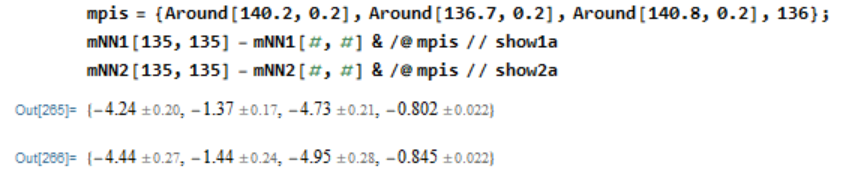

In [41]:
overwrite=False

ens2tminss={
        'b':[range(8,25+1),range(1,10+1),range(1,4+1)],
        'c':[range(8,29+1),range(1,16+1),range(1,5+1)],
        'd':[range(8,33+1),range(1,18+1),range(1,6+1)],
        'e':[range(8,39+1),range(1,18+1),range(1,5+1)],
    }
ens2selections={
    'b':{'1st':20,'2st':7,'3st':3},
    'c':{'1st':21,'2st':8,'3st':3},
    'd':{'1st':24,'2st':9,'3st':3},
    'e':{'1st':32,'2st':11,'3st':4},
}

ens2DmN={'b':(-4.44,0.27),'c':(-1.44,0.24),'d':(-4.95,0.28),'e':(-0.845,0.022)}
ens2DmN={ens:yu.jackknife_pseudo(ens2DmN[ens][0],ens2DmN[ens][1],ens2Njk[ens])[:,0] for ens in enss}

mN_exp=(yu.m_proton+yu.m_neutron)/2

figs=[]; ens2pars_jk_meff1st={}; ens2pars_jk_meff2st={}; ens2pars_jk_meff3st={}
for ens in enss:
    meff=yu.jackmap(yu.c2pt2meff,ens2c2pt0[ens])
    tminss=ens2tminss[ens]

    # tmins=[1.6,0.6,0.2]
    # tmins=[1.6,0.6,0.2]
    # tmins=[t*yu.ens2a['b'] for t in [20,7,3]]
    # selections={f'{i+1}st':yu.find_t_cloest(tmins[i],yu.ens2a[ens]) for i in range(3)}
    selections=ens2selections[ens]
    # selections={}
    print(ens,selections)
    
    fitss_2pt=yu.doFit_meff_nst(meff,tminss,[0.4,0.5,2,0.8,1],downSampling=1,label=f'meff_{ens}',overwrite=overwrite)
    fig,axd,result=yu.makePlot_2pt_SimoneStyle(meff,fitss_2pt,xunit=yu.ens2a[ens],yunit=yu.ens2aInv[ens]/1000,mN_exp=mN_exp/1000,ylims='std_N',\
        selection=selections)
    fig.suptitle(yu.ens2full[ens])
    yu.finalizePlot(closeQ=True)
    figs.append(fig) 
    
    ens2pars_jk_meff1st[ens]=result['1st']
    ens2pars_jk_meff2st[ens]=result['2st']
    ens2pars_jk_meff3st[ens]=result['3st']

enss=['b','c','d']

ens2dats=[{ens:ens2pars_jk_meffnst[ens][:,0]*yu.ens2aInv[ens] for ens in enss} for ens2pars_jk_meffnst in [ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]]
fitss=[yu.doFit_continuumExtrapolation(ens2dat,lat_a2s_plt=yum.lat_a2s_plt) for ens2dat in ens2dats]
matrix_dic=[{
    'ens2dat':ens2dats[ist],
    'fit:[fits,lat_a2s_plt]':[fitss[ist],yum.lat_a2s_plt]
    } for ist in range(len(ens2dats))]
fig,axs=yu.makePlot_continuumExtrapolation(matrix_dic,shows=['MA'])
yu.addColHeader(axs,['1st','2st','3st'])
ax=axs[0,0]
ax.set_ylim([920,960])
ax.set_ylabel(r'$m_N$ [MeV]')
for icol in range(len(matrix_dic)):
    ax=axs[0,icol]
    yu.addRefLine(ax,mN_exp,label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    ax.legend(fontsize=16)  
yu.finalizePlot(closeQ=True)
figs.append(fig)

ens2dats=[{ens:ens2pars_jk_meffnst[ens][:,0]*yu.ens2aInv[ens]+ens2DmN_lat[ens] for ens in enss} for ens2pars_jk_meffnst in [ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]]
fitss=[yu.doFit_continuumExtrapolation(ens2dat,lat_a2s_plt=yum.lat_a2s_plt) for ens2dat in ens2dats]
matrix_dic=[{
    'ens2dat':ens2dats[ist],
    'fit:[fits,lat_a2s_plt]':[fitss[ist],yum.lat_a2s_plt]
    } for ist in range(len(ens2dats))]
fig,axs=yu.makePlot_continuumExtrapolation(matrix_dic,shows=['MA'])
yu.addColHeader(axs,['1st','2st','3st'])
ax=axs[0,0]
ax.set_ylim([920,960])
ax.set_ylabel(r'$m_N$ [MeV]')
for icol in range(len(matrix_dic)):
    ax=axs[0,icol]
    yu.addRefLine(ax,mN_exp,label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    ax.legend(fontsize=16)  
fig.suptitle(r'corrected using lattice $\sigma_{\pi N}$')
yu.finalizePlot(closeQ=True)
figs.append(fig)

ens2dats=[{ens:ens2pars_jk_meffnst[ens][:,0]*yu.ens2aInv[ens]+ens2DmN[ens] for ens in enss} for ens2pars_jk_meffnst in [ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]]
fitss=[yu.doFit_continuumExtrapolation(ens2dat,lat_a2s_plt=yum.lat_a2s_plt) for ens2dat in ens2dats]
matrix_dic=[{
    'ens2dat':ens2dats[ist],
    'fit:[fits,lat_a2s_plt]':[fitss[ist],yum.lat_a2s_plt]
    } for ist in range(len(ens2dats))]
fig,axs=yu.makePlot_continuumExtrapolation(matrix_dic,shows=['MA'])
yu.addColHeader(axs,['1st','2st','3st'])
ax=axs[0,0]
ax.set_ylim([920,960])
ax.set_ylabel(r'$m_N$ [MeV]')
for icol in range(len(matrix_dic)):
    ax=axs[0,icol]
    yu.addRefLine(ax,mN_exp,label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    ax.legend(fontsize=16)  
fig.suptitle(r'corrected using $O(p^3)$ ChPT')
yu.finalizePlot(closeQ=True)
figs.append(fig)

enss=['b','c','d','e']
    
yu.makePDF('meff',figs)

label=f'ens2pars_jk_meffnst_selected'
yu.save_pkl_reg(label,[ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st])

b {'1st': 20, '2st': 7, '3st': 3}
c {'1st': 21, '2st': 8, '3st': 3}
d {'1st': 24, '2st': 9, '3st': 3}
e {'1st': 32, '2st': 11, '3st': 4}
